<h1>KNN (K-Nearest Neighbours) - Vecinos más cercanos</h1>

<h2>Es un algoritmo de clasificación, permite clasificar un nuevo dato a partir de los casos más parecidos en el conjunto de datos. Para saber cual es el dato más parecido, debe calcular distancia a todos los puntos:</h2>
<img src='https://helloacm.com/wp-content/uploads/2016/03/2012-10-26-knn-concept.png'>

<h2>La forma más común de calcular estas distancias es mediante la distancia euclidiana, una formula matematica basada en el teorema de Pitagoras, la ecuacion es:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/Distance_Formula.svg/375px-Distance_Formula.svg.png'>
<img src='https://wikimedia.org/api/rest_v1/media/math/render/svg/92d49b1b717fc1b18de1b7bebddc78d56b9ac79c' style='background-color: white'>

<h1>Estas distancias se calculan para todo el conjunto de datos, y el punto con la distancia más corta sera elegida como la clase más "afin", en base a esa clase clasificaremos a este nuevo dato. Pero clasificar en base a un solo punto cercano no es algo fiable, para eso hay que definir un K, K nos dice cuantos puntos tomar (los K más cercanos), una vez que tenemos los K puntos más cercanos, el algoritmo escoge entre la clase que más abunda dentro de esos puntos (hace una especie de votación).</h1>

<h2>En el caso de variables binarias (por ejemplo genero) donde sus valores son 0 y 1 la distancia a utilizar es la distancia de Hamming, simplemente compara los numeros binarios de dos puntos retornando 1 si son iguales y 0 si son diferentes, veamoslo con un ejemplo:

Consideremos un dataset cuyos datos tienen como propiedad Genero, Diabetes e Hipertensión, todas binarias (1 significa masculino/si, 0 femenino/no), un dato ya existente tiene SI (1) en estas 3 propiedades (111), ahora se introduce un nuevo dato el cual solo coincide en Genero (100), lo que hara Hamming es ordenar los valores y contar las posiciones en que no coincidan:

dist(111 ; 100) = 2, es decír, en dos propiedades no coinciden (Diabetes e Hipertension). Este valor podemos dividirlo por el numero de variables binarias (2/3 o 0.66) para mantener numeros pequeños. La unica condición que tiene la distancia de Hamming, es que la longitud a comparar debe ser igual en los dos datos.</h2>

<h2>Cuando tenemos variables categoricas el calculo de la distancia es más o menos parecido, supongamos que tenemos un dataset de personas donde las caracteristicas son Deporte y Profesion:

Un dato ya existente tiene Deporte=Tenis, Profesion=Ingeniero, se quiere clasificar un nuevo dato el cual Deporte=Tenis, Profesion=Bioquimico, por lo tanto la distancia se calcula cantidad_aciertos/total_caracteristicas, en este caso la cantidad de aciertos es 1 (Deporte) y la cantidad de caracteristicas 2, por lo tanto.

d(persona_existente/persona_nueva)=1/2=0.5.

Una consideración a tener cuando calculamos distancias entre variables categoricas, es la cantidad de valores posibles dentro de ellas, por ejemplo, una caracteristica "estado_civil" generalmente va a tener 4 valores posibles: soltero, casado, viudo, divorciado a diferencia de "profesión" donde podemos tener multiples valores a comparar, una solución posible es asignar pesos altos a las variables con menos valores distintos ("estado_civil") y pesos bajos a variables que pueden contener multiples valores ("profesion"), de tal forma de que cada vez que dos valores sean distintos en una variable categorica que toma multiples valores, esto no afecte tanto al calculo de la distancia total.</h2>


In [19]:
### Comencemos con el dataset a utilizar para nuestro KNN ##
### El dataset contiene datos sobre frutas y su clasificacion en base a dimensiones, pesos, etc. ###
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_csv("https://raw.githubusercontent.com/rocksaint/fruit-data-with-colours/master/fruit_data_with_colours.csv")
df.head(5)

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [2]:
### Analisis de datos ###
df.columns

Index(['fruit_label', 'fruit_name', 'fruit_subtype', 'mass', 'width', 'height',
       'color_score'],
      dtype='object')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fruit_label    59 non-null     int64  
 1   fruit_name     59 non-null     object 
 2   fruit_subtype  59 non-null     object 
 3   mass           59 non-null     int64  
 4   width          59 non-null     float64
 5   height         59 non-null     float64
 6   color_score    59 non-null     float64
dtypes: float64(3), int64(2), object(2)
memory usage: 3.4+ KB


In [4]:
# Conteo de nulos
df.isnull().sum()

fruit_label      0
fruit_name       0
fruit_subtype    0
mass             0
width            0
height           0
color_score      0
dtype: int64

In [5]:
# Valores unicos
df['fruit_label'].unique()

array([1, 2, 3, 4])

In [6]:
df['fruit_name'].unique()

array(['apple', 'mandarin', 'orange', 'lemon'], dtype=object)

In [9]:
df['fruit_subtype'].unique()

array(['granny_smith', 'mandarin', 'braeburn', 'golden_delicious',
       'cripps_pink', 'spanish_jumbo', 'selected_seconds', 'turkey_navel',
       'spanish_belsan', 'unknown'], dtype=object)

In [12]:
# Visualizemos subtipo dentro de cada fruta y hagamos un conteo
df.groupby(['fruit_name'])['fruit_subtype'].value_counts().to_frame()

fruit_subtype
fruit_name fruit_subtype                  
apple      cripps_pink                   6
           braeburn                      5
           golden_delicious              5
           granny_smith                  3
lemon      unknown                      10
           spanish_belsan                6
mandarin   mandarin                      5
orange     turkey_navel                 10
           selected_seconds              6
           spanish_jumbo                 3

In [7]:
# Indicadores estadisticos
df.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


In [13]:
### Vemos que mass (masa) tiene una gran desviación estandar, ademas el 75% de sus valores se encuentran por debajo de 177
### Chequeo de posibles outliers
df[df['mass'] > 200]

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
24,3,orange,spanish_jumbo,342,9.0,9.4,0.75
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
26,3,orange,spanish_jumbo,362,9.6,9.2,0.74
27,3,orange,selected_seconds,204,7.5,9.2,0.77
31,3,orange,selected_seconds,210,7.8,8.0,0.82
46,4,lemon,spanish_belsan,216,7.3,10.2,0.71


In [14]:
df[df['fruit_subtype'] == 'spanish_jumbo']

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
24,3,orange,spanish_jumbo,342,9.0,9.4,0.75
25,3,orange,spanish_jumbo,356,9.2,9.2,0.75
26,3,orange,spanish_jumbo,362,9.6,9.2,0.74


In [16]:
### Es una caracteristica de ese tipo de naranja por lo tanto no se elimina
# veamos por cada fruta y su tipo ###
df.groupby(['fruit_name', 'fruit_subtype']).agg({'mass': ['mean', 'std', 'min', 'max']})

mass                     
                                   mean        std  min  max
fruit_name fruit_subtype                                    
apple      braeburn          168.400000   9.099451  154  178
           cripps_pink       158.333333  10.073066  140  170
           golden_delicious  159.200000   6.572671  152  168
           granny_smith      182.666667   8.326664  176  192
lemon      spanish_belsan    194.333333  14.052283  174  216
           unknown           123.400000  11.663809  116  152
mandarin   mandarin           81.200000   3.898718   76   86
orange     selected_seconds  172.666667  27.904599  140  210
           spanish_jumbo     353.333333  10.263203  342  362
           turkey_navel      158.600000  15.174540  142  190

In [17]:
### Podemos observar ciertos outliers en subtipos (selected_seconds) ###
df[df['fruit_subtype'] == 'selected_seconds']

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
27,3,orange,selected_seconds,204,7.5,9.2,0.77
28,3,orange,selected_seconds,140,6.7,7.1,0.72
29,3,orange,selected_seconds,160,7.0,7.4,0.81
30,3,orange,selected_seconds,158,7.1,7.5,0.79
31,3,orange,selected_seconds,210,7.8,8.0,0.82
32,3,orange,selected_seconds,164,7.2,7.0,0.80


In [20]:
### Eliminamos esos outliers ###
df = df[~((df['fruit_subtype'] == 'selected_seconds') & (df['mass'] > 200))].reset_index(drop=True)
df

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79
5,2,mandarin,mandarin,80,5.8,4.3,0.77
6,2,mandarin,mandarin,80,5.9,4.3,0.81
7,2,mandarin,mandarin,76,5.8,4.0,0.81
8,1,apple,braeburn,178,7.1,7.8,0.92
9,1,apple,braeburn,172,7.4,7.0,0.89


<Axes: xlabel='width', ylabel='height'>

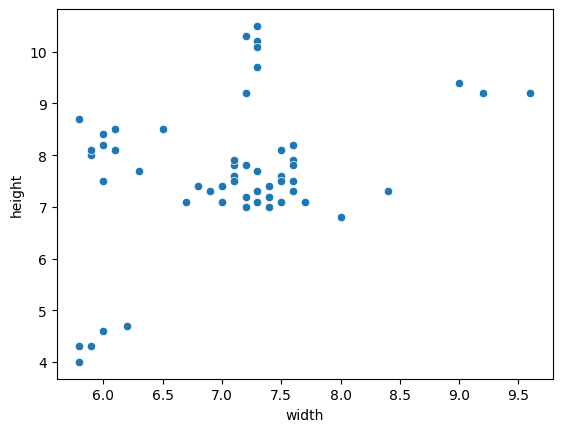

In [21]:
### Visualizaciones sobre las caracteristicas de cada fruta ###
#Height y Width tienen clusters bien definidos
sns.scatterplot(data=df, x="width", y="height")

<Axes: xlabel='mass', ylabel='height'>

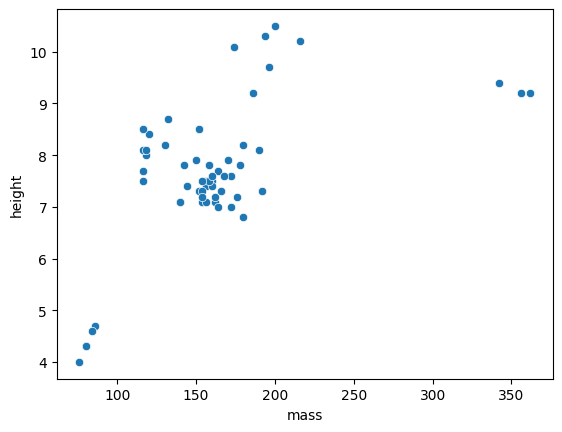

In [23]:
sns.scatterplot(data=df, x="mass", y="height")

<Axes: xlabel='mass', ylabel='width'>

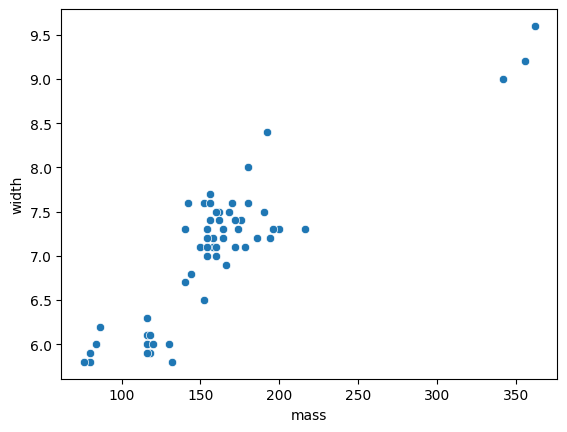

In [24]:
sns.scatterplot(data=df, x="mass", y="width")

In [29]:
# Veamos relación entre las caracteristicas
# mass y width tienen un alto indice de correlación
# se puede testear KNN eliminando una de ellas
df[['mass', 'width',	'height',	'color_score']].corr().round(2)

,mass,width,height,color_score
mass,1.00,0.88,0.61,-0.09
width,0.88,1.00,0.39,-0.09
height,0.61,0.39,1.00,-0.26
color_score,-0.09,-0.09,-0.26,1.00


In [189]:
# Importamos KNN de sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
# X sera una lista con las variables independientes
# Y sera la variable a predecir (fruit_label)
X = df[['mass', 'width', 'height']]
Y = df['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=46)

In [190]:
X_train.count(), X_test.count()

(mass      45
 width     45
 height    45
 dtype: int64,
 mass      12
 width     12
 height    12
 dtype: int64)

In [191]:
# Instanciamos el clasificador, pero antes vamos a ver el K optimo con GridSearch
# Tambien probaremos con el parametro "weights"
# Este parametro sirve para testar el algoritmo con pesos uniforme o con pesos ponderados de acuerdo a la distancia de cada vecino con el nuevo punto
from sklearn.model_selection import GridSearchCV
parameters = {
      "n_neighbors": range(1, 10),
      "weights": ["uniform", "distance"],
    }
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 10),
                         'weights': ['uniform', 'distance']})

In [192]:
# El mejor K es 9 con pesos no uniformes
gridsearch.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

In [196]:
# Instanciamos y entrenamos el modelo
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')
# model training
knn.fit(X_train,y_train)
# testing the model
y_pred= knn.predict(X_test)

In [197]:
# importing accuracy_score
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

0.9166666666666666


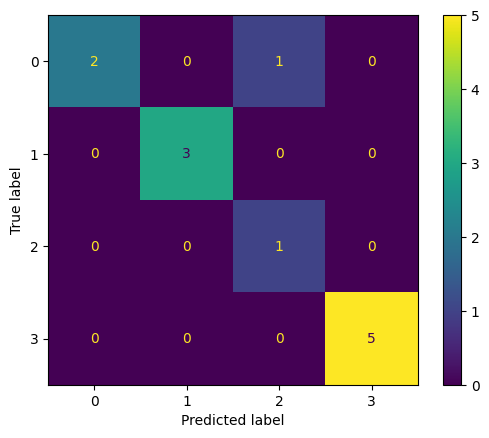

In [207]:
### Evaluamos la performance de nuestro algoritmo con la matriz de confusion ###

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
# Proveemos datos testeo y sus predicciones
cm = confusion_matrix(y_test, y_pred)
# Graficamos
ConfusionMatrixDisplay(cm).plot()

<h2>Vamos a predecir nuevas clases proporcionando valores de las 3 variables (mass, width, height)</h2>

In [210]:
df[['fruit_label', 'fruit_name', 'mass', 'width', 'height']].sample(5)

,fruit_label,fruit_name,mass,width,height
3,2,mandarin,86,6.2,4.7
1,1,apple,180,8.0,6.8
43,4,lemon,186,7.2,9.2
30,3,orange,164,7.2,7.0
40,3,orange,154,7.2,7.2


In [211]:
# Les pasamos datos para predecir con las 3 variables (mass, width y height)
prediction1=knn.predict([[86, 6.2, 4.7]])
print(prediction1[0]) # mandarin (OK)

2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [212]:
prediction2=knn.predict([[180, 8, 6.8]])
print(prediction2[0]) # apple (OK)

1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [213]:
prediction3=knn.predict([[186, 7.2, 9.2]])
print(prediction3[0]) # lemon (OK)

4


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


<h1>CONCLUSIONES</h1>

<h3>Nuestro modelo KNN esta basado en una semilla aleatoria=46, la misma puede calcularse en un for loop para lograr la más eficiente.
También se aplico GridSearch para encontrar el K optimo (7) y la ponderación
(no uniforme, es decír, asignara pesos mayores a los puntos más cercanos al nuevo punto). El accuracy de nuestro modelo es 0.91, la matriz de confusión expresa que casi la totalidad de las predicciones sobre el conjunto de testeo fueron correctas, salvo una manzana que predijo como orange (label era 1 y lo predijo como 3), se testearon 3 datos aleatorios y las predicciones fueron correctas.</h3>